In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import molsysmt as msm
import openexplorer as oe
import numpy as np
from simtk import unit
from simtk.openmm import app
from tqdm import tqdm
import matplotlib.pyplot as plt

# MonteCarlo

In [3]:
modeller = msm.convert('alanine_dipeptide.pdb', to_form='openmm.Modeller')

topology = modeller.topology
positions = modeller.positions

forcefield = app.ForceField('amber10.xml', 'amber10_obc.xml')
system = forcefield.createSystem(topology, constraints=app.HBonds, nonbondedMethod=app.NoCutoff)

explorer = oe.Explorer(topology, system, platform='CUDA')

In [4]:
explorer.set_coordinates(positions)

In [5]:
quartets = msm.covalent_dihedral_quartets(explorer, dihedral_angle='all')

In [6]:
explorer.quench.l_bfgs()

In [7]:
print(msm.get_dihedral_angles(explorer, quartets=quartets))

[[-91.95678817   9.83976544 169.37542528]] deg


In [8]:
explorer.move.dihedral_shifts.set_parameters(dihedral_angle='all', mode_angles='random',
                                             n_random_angles=1, stepsize=10.0*unit.degrees,
                                             mode_steps='random')

In [9]:
explorer.acceptance.metropolis_hastings.set_parameters(temperature=900.0*unit.kelvin)

In [10]:
acceptance = explorer.acceptance.metropolis_hastings

In [11]:
traj = []

for ii in tqdm(range(25000)):
    previous_coordinates = explorer.get_coordinates()
    explorer.move.dihedral_shifts()
    acceptance(previous_coordinates=previous_coordinates)
    traj.append(msm.get_dihedral_angles(explorer, quartets=quartets)._value)

100%|██████████| 25000/25000 [00:56<00:00, 444.70it/s]


In [12]:
explorer.acceptance.metropolis_hastings.n_tries

25000

In [13]:
explorer.acceptance.metropolis_hastings.n_accepted

9642

In [14]:
traj = np.array(traj)

In [15]:
print(traj.shape)

(25000, 1, 3)


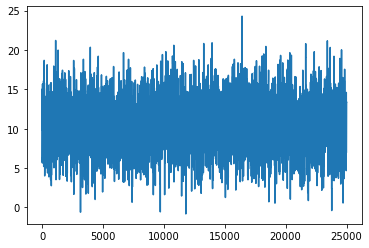

In [16]:
plt.plot(traj[:,0,1])
plt.show()

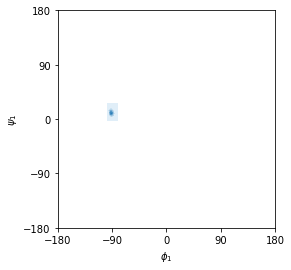

In [17]:
import seaborn as sns

ax = sns.kdeplot(traj[:,0,0], traj[:,0,1], shade=True)
ax.set_xlim(-180.0,180.0)
ax.set_ylim(-180.0,180.0)
ax.set_xticks([-180.0, -90.0, 0.0, 90.0, 180.0])
ax.set_yticks([-180.0, -90.0, 0.0, 90.0, 180.0])
ax.set_xlabel('$\phi_1$')
ax.set_ylabel('$\psi_1$')
ax.set_aspect('equal')